# Bayesian Optimization: practical edition

In [1]:
def get_free_gpu():
    from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlDeviceGetCount
    nvmlInit()

    return np.argmax([
        nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(i)).free
        for i in range(nvmlDeviceGetCount())
    ])

In [2]:
import numpy as np
import torch

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

if torch.cuda.is_available():
    cuda_id = get_free_gpu()
    DEVICE = 'cuda:%d' % (get_free_gpu(), )
    print('Selected %s' % (DEVICE, ))
else:
    DEVICE = 'cpu'
    print('WARNING: using cpu!')

### please, don't remove the following line
x = torch.tensor([1], dtype=torch.float32).to(DEVICE)

Selected cuda:2


## imports

In this notebook, we are going to use `pyro`, however, there are multiple alternatives:
- [`scikit-optimize`](https://pypi.org/project/scikit-optimize/)
- [`gpytorch`](https://gpytorch.ai/)
- [`sklearn`](https://scikit-learn.org/stable/modules/gaussian_process.html)
- [`tfp`](https://www.tensorflow.org/probability/examples/Gaussian_Process_Latent_Variable_Model)

In [3]:
import pyro
pyro.set_rng_seed(111222333)

from pyro.contrib.gp.models import GPRegression
from pyro.contrib.gp.kernels import RBF, Matern32, Matern52, Polynomial

In [4]:
def simple_objective(x):
    return np.exp(-2 * x + 1) + np.exp(x) - 2.5

X = np.array([0.1, 0.4, 0.9])
y = simple_objective(X)

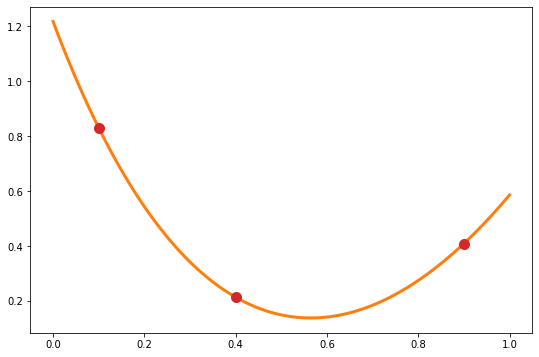

In [5]:
xs = np.linspace(0, 1, num=100)
plt.figure(figsize=(9, 6))
plt.plot(xs, simple_objective(xs), color=plt.cm.tab10(1), lw=3)
plt.scatter(X, y, s=100, color=plt.cm.tab10(3), zorder=3)
plt.show()

In [6]:
def plot_gp(gp, X=None, y=None, objective=None):
    with torch.no_grad():
        xs = torch.linspace(0, 1, 100, device=DEVICE, dtype=torch.float32)
        mean, cov =  gp(xs.view(-1, 1), full_cov=True, noiseless=False)
        std = torch.sqrt(cov.diag())

    xs_ = xs.cpu().numpy()
    mean_ = mean.cpu().numpy()
    std_ = std.cpu().numpy()
    
    if X is not None and y is not None:
        plt.scatter(X, y, color=plt.cm.tab10(0), s=100)
    
    if objective is not None:
        plt.plot(xs_, objective(xs_), '--', color='black')
    
    plt.plot(xs_, mean_, lw=2)
    plt.fill_between(
        xs_, mean_ - std_, mean_ + std_,
        alpha=0.2,
        color=plt.cm.tab10(0)
    )

In [7]:
pyro.clear_param_store()
gp = GPRegression(
    torch.tensor(X.reshape(-1, 1), dtype=torch.float32, device=DEVICE),
    torch.tensor(y.reshape(-1), dtype=torch.float32, device=DEVICE),

    noise=torch.tensor(1e-2),
    kernel=RBF(
        input_dim=1,
        variance=torch.tensor(1, dtype=torch.float32, device=DEVICE),
        lengthscale=torch.tensor(0.25, dtype=torch.float32, device=DEVICE)
    ),
).to(DEVICE)

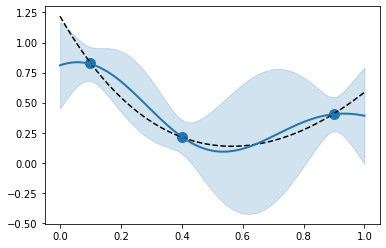

In [8]:
plot_gp(gp, X, y, objective=simple_objective)

## Multi-start

An aquisition can easily have multiple minima. At the same time grid and random searches are inefficient even
for a cheap surrogate as GP (trained on a few point). Typically, multi-start algorithm is employed - several instances of gradient descent start from a randomly drawn locations.

In [9]:
def minimize_acq(x0, gp, acq, lr=1e-1, n_iters=128, progress_bar=lambda x: x):
    x = torch.tensor(x0, dtype=torch.float32, device=DEVICE, requires_grad=True)
    
    ### not stochastic in this case
    opt = torch.optim.SGD(lr=lr, params=[x])
    
    for _ in progress_bar(range(n_iters)):
        opt.zero_grad()        
        torch.sum(acq(gp, x)).backward()
        opt.step()
        
        with torch.no_grad():
            x = torch.clamp(x, 0, 1)

    with torch.no_grad():
        values = acq(gp, x)

    return x.detach().cpu().numpy(), values.detach().cpu().numpy()

### Lower confidence bound

Simple, yet effective: $$\mathrm{LCB}(x) = \mu(x) - \alpha\cdot\sigma(x)$$

In [10]:
def lcb(gp, x, alpha=1.0):
    mean, cov = gp(x, full_cov=True, noiseless=False)
    std = torch.sqrt(cov.diag())
    
    return mean - alpha * std

In [11]:
### checking if multi-start properly optimizes aquisition function
x0 = np.random.uniform(0, 1, size=25).reshape(-1, 1)
with torch.no_grad():
    v0 = lcb(
        gp, torch.tensor(
            x0, dtype=torch.float32,
            device=DEVICE, requires_grad=False
        )
    ).detach().cpu().numpy()

x, v = minimize_acq(
    x0 = x0,
    gp=gp,
    acq=lcb,
    n_iters=128,
    progress_bar=tqdm
)

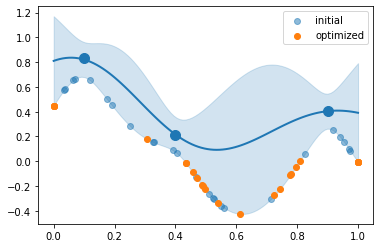

In [12]:
plot_gp(gp, X, y)
plt.scatter(x0[:, 0], v0, color=plt.cm.tab10(0), alpha=0.5, label='initial')
plt.scatter(x[:, 0], v, color=plt.cm.tab10(1), label='optimized')
plt.legend(loc='upper right')

## Bayesian Optimization

In [13]:
class BayesianOptimization(object):
    def __init__(self, gp_model, acq, lr=1e-1, ndim=1, n_multi_start=32, warmup=2):
        self.gp_model = gp_model
        self.gp = None

        self.acq = acq
        self.ndim = ndim
        self.n_multi_start = n_multi_start
        self.warmup = warmup
        
        self.X = list()
        self.y = list()
    
    def reset(self, ):
        self.X = list()
        self.y = list()
        self.gp = None
    
    def ask(self):
        if len(self.X) < self.warmup:
            return np.random.uniform(0, 1, size=self.ndim)
        
        ### optimizing aquisition function
        suggestions, values = minimize_acq(
            x0=np.random.uniform(0, 1, size=(self.n_multi_start, self.ndim)),
            gp=self.gp,
            acq=self.acq
        )

        ### returning the best guess
        best = np.argmin(values)
        return suggestions[best]
    
    def tell(self, x, y):
        self.X.append(x)
        self.y.append(y)
        
        X = torch.tensor(self.X, dtype=torch.float32, device=DEVICE).view(-1, self.ndim)
        y = torch.tensor(self.y, dtype=torch.float32, device=DEVICE).view(-1,)
        
        ### 'retraining' model
        pyro.clear_param_store()
        self.gp = self.gp_model(X, y)

In [14]:
bo = BayesianOptimization(
    gp_model=lambda X, y: GPRegression(
        X, y,
        noise=torch.tensor(1e-4),
        kernel=RBF(
            input_dim=1,
            variance=torch.tensor(1, dtype=torch.float32, device=DEVICE),
            lengthscale=torch.tensor(2e-1, dtype=torch.float32, device=DEVICE)
        ),
    ).to(DEVICE),
    
    acq=lcb
)

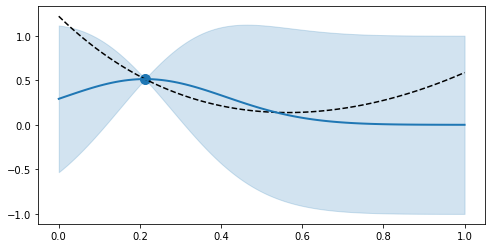

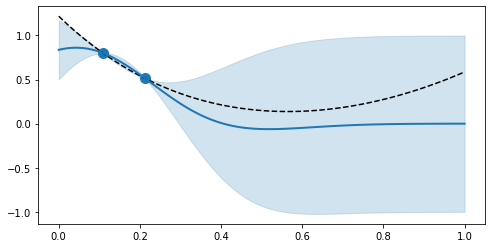

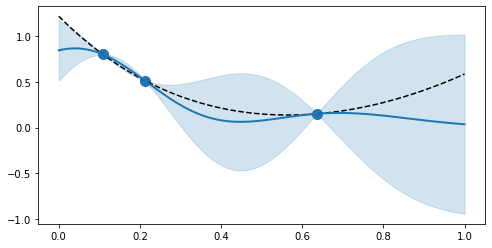

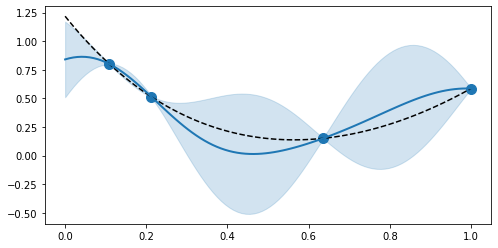

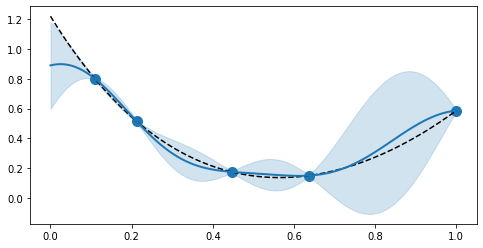

In [15]:
bo.reset()

for _ in range(5):
    x = bo.ask()
    y = simple_objective(x)
    
    bo.tell(x, y)
    
    plt.figure(figsize=(8, 4))
    plot_gp(bo.gp, X=np.array(bo.X), y=np.array(bo.y), objective=simple_objective)
    plt.show()

## More challenge!

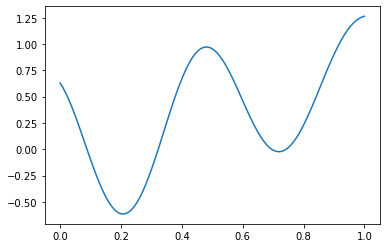

In [16]:
def objective_2_minima(x):
    return 0.75 * np.sin(-12 * x + 1) * np.cos(x) + 0.5 * np.exp(x) - 0.5

xs = np.linspace(0, 1, num=100)
plt.plot(xs, objective_2_minima(xs))

In [17]:
bo = BayesianOptimization(
    gp_model=lambda X, y: GPRegression(
        X, y,
        noise=torch.tensor(1e-4),
        ### switched to Matern kernel
        kernel=Matern32(
            input_dim=1,
            variance=torch.tensor(1, dtype=torch.float32, device=DEVICE),
            lengthscale=torch.tensor(0.25, dtype=torch.float32, device=DEVICE)
        ),
    ).to(DEVICE),
    acq=lcb
)

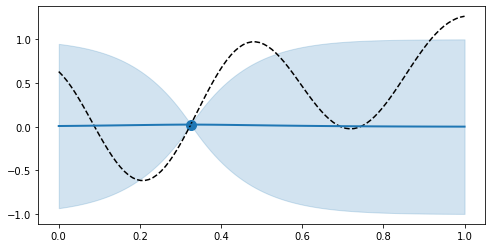

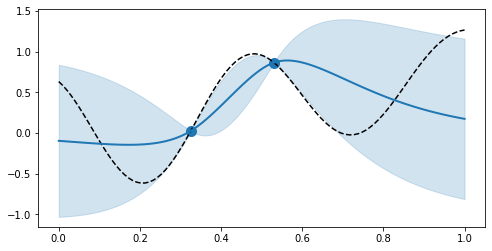

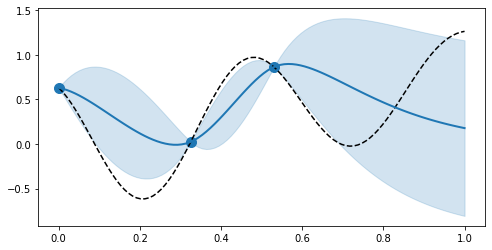

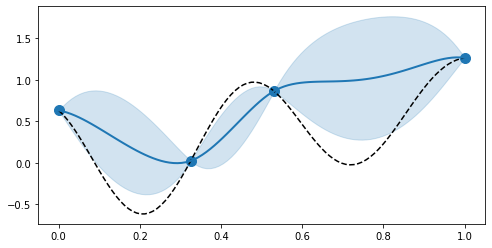

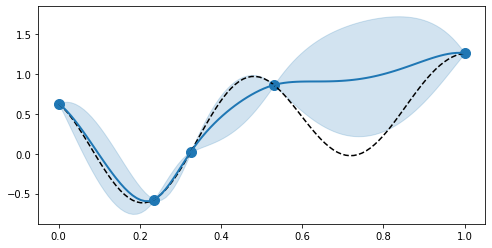

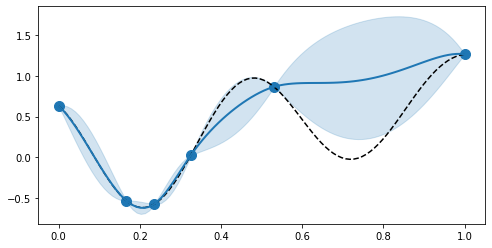

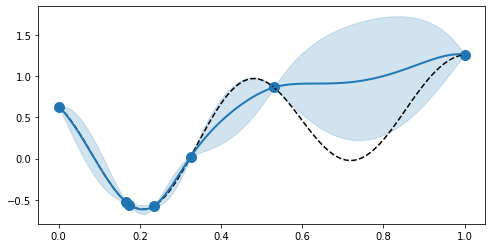

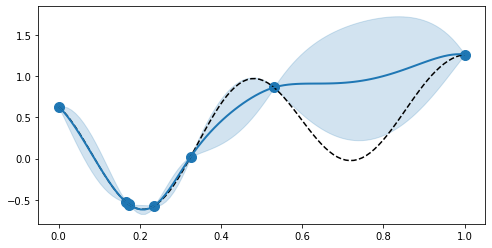

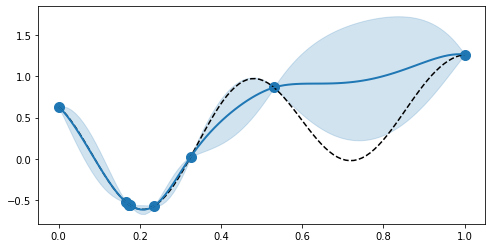

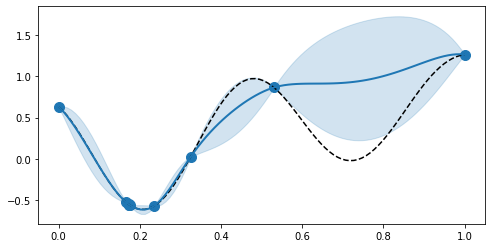

In [18]:
bo.reset()

for _ in range(10):
    x = bo.ask()
    y = objective_2_minima(x)
    
    bo.tell(x, y)
    
    plt.figure(figsize=(8, 4))
    plot_gp(bo.gp, X=np.array(bo.X), y=np.array(bo.y), objective=objective_2_minima)
    plt.show()

## Take it to the limit

Let's see if GP can approximate a complex function.

In [19]:
### Purely explorative acquisition function.
def exlorative(gp, x, alpha=1.0):
    mean, cov = gp(x, full_cov=True, noiseless=False)
    std = torch.sqrt(cov.diag())
    
    return - std

### Purely exploitative acquisition function.
def exploitative(gp, x, alpha=1.0):
    mean, cov = gp(x, full_cov=True, noiseless=False)
    std = torch.sqrt(cov.diag())
    
    return mean

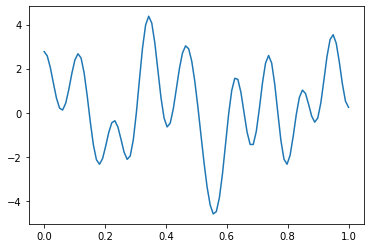

In [20]:
m = 20
w = np.random.uniform(-1, 1, size=m)
periods = np.arange(1, m + 1) * np.pi

def objective_many_minima_much_challenge(x):
    return np.sum(
        w[:, None] * np.cos(x[None, :] * periods[:, None]),
        axis=0
    ) + x ** 2

xs = np.linspace(0, 1, num=100)
plt.plot(xs, objective_many_minima_much_challenge(xs))

### Approximation check

In [21]:
bo = BayesianOptimization(
    gp_model=lambda X, y: GPRegression(
        X, y,
        noise=torch.tensor(1e-4),
        ### switched to Matern kernel
        kernel=Matern32(
            input_dim=1,
            variance=torch.tensor(1, dtype=torch.float32, device=DEVICE),
            lengthscale=torch.tensor(0.1, dtype=torch.float32, device=DEVICE)
        ),
    ).to(DEVICE),
    acq=exlorative
)

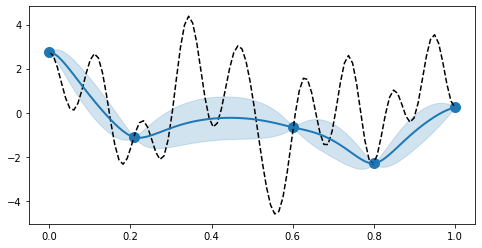

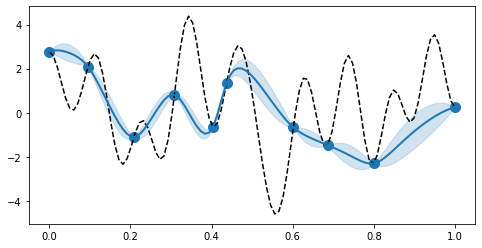

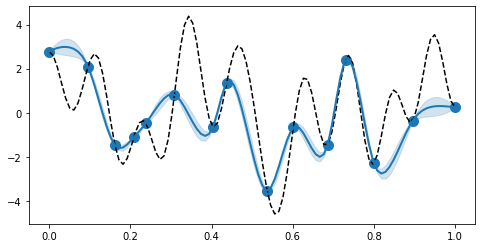

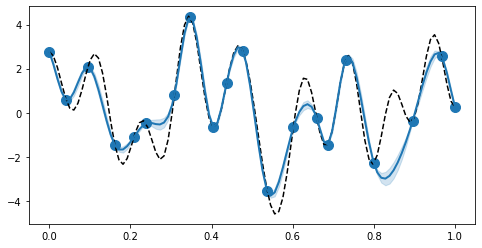

In [22]:
bo.reset()

for i in range(20):
    x = bo.ask()
    y = objective_many_minima_much_challenge(x)
    
    bo.tell(x, y)
    
    if (i + 1) % 5 == 0:
        plt.figure(figsize=(8, 4))
        plot_gp(bo.gp, X=np.array(bo.X), y=np.array(bo.y), objective=objective_many_minima_much_challenge)
        plt.show()

### Optimization check

In [23]:
bo = BayesianOptimization(
    gp_model=lambda X, y: GPRegression(
        X, y,
        noise=torch.tensor(1e-4),
        ### switched to Matern kernel
        kernel=Matern32(
            input_dim=1,
            variance=torch.tensor(2, dtype=torch.float32, device=DEVICE),
            lengthscale=torch.tensor(0.1, dtype=torch.float32, device=DEVICE)
        ),
    ).to(DEVICE),
    acq=lcb
)

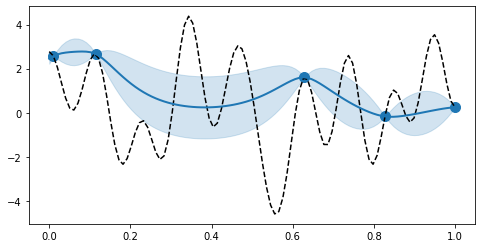

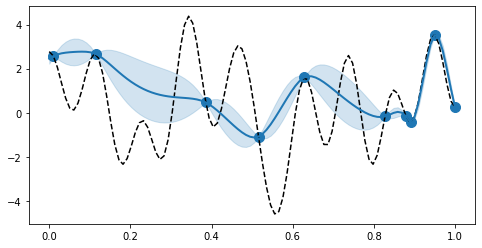

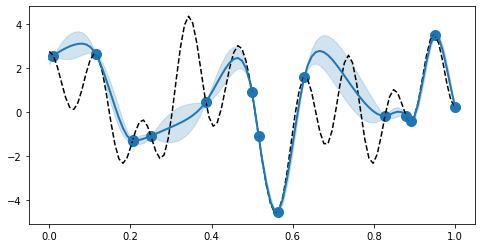

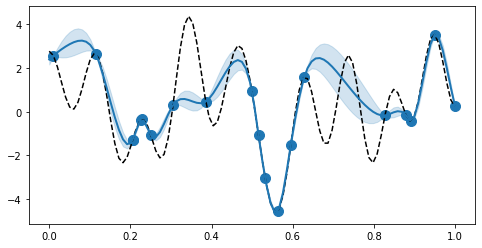

In [24]:
bo.reset()

for i in range(20):
    x = bo.ask()
    y = objective_many_minima_much_challenge(x)
    
    bo.tell(x, y)
    
    if (i + 1) % 5 == 0:
        plt.figure(figsize=(8, 4))
        plot_gp(bo.gp, X=np.array(bo.X), y=np.array(bo.y), objective=objective_many_minima_much_challenge)
        plt.show()

## Hyper-parameter optimization

In [25]:
data = np.load('../../../share/HIGGS-small.npy')

In [26]:
from sklearn.model_selection import train_test_split

X_all, y_all = data[:, 1:], data[:, 0]

### casting labels to int
y_all = np.where(y_all > 0.5, np.int(1), np.int(0))

X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.25)

print('Train     :', X_train.shape, y_train.shape)
print('Validation:', X_val.shape, y_val.shape)

Train     : (75000, 28) (75000,)
Validation: (25000, 28) (25000,)


## Task 1

Apply BO-GP to find the best number of trees and learning rate for `GradientBoostingClassifier`on the HIGGS dataset.

The objective function consist of two term terms:
- 1 - ROC AUC;
- complexity penalty (number of trees).

Don't forget to change the number of dimensions in `BayesianOptimization`: `BayesianOptimization(..., ndim=2)`.

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

def get_gb(x):
    n_trees = int(100 * x[0] + 1)
    log_learning_rate = x[1] * 6 - 3
    learning_rate = np.exp(log_learning_rate)

    return GradientBoostingClassifier(
        learning_rate=learning_rate,
        n_estimators=n_trees, max_depth=3,
        subsample=0.1, random_state=123
    )

def objective(x):
    clf = get_gb(x)
    
    predictions = clf.fit(X_train, y_train).predict_proba(X_val)[:, 1]
    
    error = 1 - roc_auc_score(y_val, predictions)
    computational_penalty = 1e-1 * x[0]
    
    return error + computational_penalty

In [28]:
bo = BayesianOptimization(
    gp_model = lambda X, y: GPRegression(X, y,
        noise=torch.tensor(1e-4), kernel=Matern32(input_dim=1,
        variance=torch.tensor(1, dtype=torch.float32, device=DEVICE),
        lengthscale=torch.tensor(0.5, dtype=torch.float32, device=DEVICE))).to(DEVICE),
    ndim=2, acq=lcb
)

In [29]:
bo.reset()

for _ in tqdm(range(20)):
    x = bo.ask()
    y = objective(x)
    
    bo.tell(x, y)

### looking for the best guess with an exploitative acqusition function
suggestions, values = minimize_acq(
    x0=np.random.uniform(0, 1, size=(128, 2)),
    gp=bo.gp,
    n_iters=1024,
    progress_bar=tqdm,
    acq=exploitative
)
best = np.argmin(values)
best_guess = suggestions[best]

In [30]:
clf = get_gb(best_guess)
    
predictions = clf.fit(X_train, y_train).predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, predictions)
computational_penalty = 1e-1 * x[0]

print('ROC AUC: %.3lf' % (auc, ))
print('complexity: %.3lf' % (computational_penalty, ))

assert True

ROC AUC: 0.665
complexity: 0.009
